In [1]:
import os, sys, re, io, math, json
import matplotlib, shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.patches import Patch
from matplotlib.widgets import Slider
from collections import *
from math import isnan, nan
from glob import glob
from ipywidgets import *
from datetime import datetime, timedelta
from termcolor import colored
import ipywidgets as widgets
from IPython.display import *
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.display.width = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 100000
pd.options.display.float_format = '{0:f}'.format

# Disable scrolling for all output widgets
style = """
    <style>
       .jupyter-widgets-output-area .output_scroll {
            height: unset !important;
            border-radius: unset !important;
            -webkit-box-shadow: unset !important;
            box-shadow: unset !important;
        }
        .jupyter-widgets-output-area  {
            height: auto !important;
        }
    </style>
    """
display(HTML(style))

# disable autosave so that multiple user browser can attach the same notebook
%autosave 0

from core import *

# enable notebook mode so that we can drag, resize and save plots, but plot will be smaller
# %matplotlib notebook

Autosave disabled


<IPython.core.display.Javascript object>

In [2]:
# main file path
PATH="./3.decrypted/izedAa85XXrDS85XlwrOsIDU"

# Check Consistency between taps and sociabilities

In [3]:
def on_button_clicked(b):
    for userpath in sorted(os.listdir(PATH)):
        if os.path.isdir(PATH+'/'+userpath):
            print('Checking %s ...' % userpath)
            df_taps = load_df(PATH+'/'+userpath+'/tapsLog.csv.gz', '', -1)
            df_acctap = load_df(PATH+'/'+userpath+'/accessibilityLog.csv.gz', '', -1)
            df_socmsg = load_df(PATH+'/'+userpath+'/sociabilityMsgLog.csv.gz', '', -1)
            df_socall = load_df(PATH+'/'+userpath+'/sociabilityCallLog.csv.gz', '', -1)
            if len(df_socmsg.index) == len(df_socall.index) == 0:
                df_whatsapp_taps = Try(lambda: df_taps[df_taps.in_app_name.str.contains('whatsapp')], pd.DataFrame())
                if len(df_whatsapp_taps.index)>0:
                    print('n_socmsg=%d, n_socall=%s, but n_whatsapp_taps=%d'%(len(df_socmsg.index), len(df_socall.index), len(df_whatsapp_taps.index)))
                    print(df_whatsapp_taps)
            if len(df_taps.index)>0 and len(df_acctap.index)==0:
                print('n_taps=%d but n_acctap=%d'%(len(df_taps.index), len(df_acctap.index)))
    print('All finished!')
button = widgets.Button(description='Check Consistency', style={'font_weight': 'bold'})
button.on_click(on_button_clicked)
display(button)

Button(description='Check Consistency', style=ButtonStyle(font_weight='bold'))

# Data Completeness Check

Button(description='Start Check', style=ButtonStyle())

Loading data from moht.dsth.001@moht.com.sg_a8077a5dd3e8 .............ambientLight=235/235 accessibilityLog=235/235 tapsLog=235/235 callLog=235/235 smsLog=235/235 sociabilityMsgLog=235/235 sociabilityCallLog=235/235 heart=208/235 sleep=205/235 steps=235/235 accel=207/235 gps=235/235 powerState=235/235 Done
Loading data from moht.dsth.002@moht.com.sg_33d64d38513f .............ambientLight=20/22 accessibilityLog=20/22 tapsLog=20/22 callLog=21/22 smsLog=21/22 sociabilityMsgLog=21/22 sociabilityCallLog=21/22 heart=22/22 sleep=20/22 steps=22/22 accel=20/22 gps=20/22 powerState=20/22 Done
Loading data from moht.dsth.003@moht.com.sg_cdb01556d05e .............ambientLight=211/211 accessibilityLog=211/211 tapsLog=211/211 callLog=211/211 smsLog=211/211 sociabilityMsgLog=211/211 sociabilityCallLog=211/211 heart=211/211 sleep=211/211 steps=211/211 accel=210/211 gps=211/211 powerState=211/211 Done
Loading data from moht.dsth.004@moht.com.sg_77c22e42696d .............ambientLight=197/197 accessibili

,accel,accessibilityLog,ambientLight,callLog,gps,heart,powerState,sleep,smsLog,sociabilityCallLog,sociabilityMsgLog,steps,tapsLog,<AggMEAN>
S001,0.880851,1.000000,1.000000,1.000000,1.000000,0.885106,1.000000,0.872340,1.000000,1.000000,1.000000,1.000000,1.000000,0.972177
S002,0.909091,0.909091,0.909091,0.954545,0.909091,1.000000,0.909091,0.909091,0.954545,0.954545,0.954545,1.000000,0.909091,0.937063
S003,0.995261,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999635
S004,1.000000,1.000000,1.000000,1.000000,1.000000,0.883249,1.000000,0.832487,1.000000,1.000000,1.000000,0.974619,1.000000,0.976181
S005,1.000000,1.000000,1.000000,1.000000,0.976744,0.918605,1.000000,0.587209,1.000000,1.000000,1.000000,1.000000,1.000000,0.960197
S006,1.000000,1.000000,1.000000,1.000000,1.000000,0.994083,1.000000,0.982249,1.000000,1.000000,1.000000,1.000000,1.000000,0.998179
S007,1.000000,1.000000,1.000000,1.000000,1.000000,0.994286,1.000000,0.931429,1.000000,1.000000,1.000000,1.000000,1.000000,0.994286
S008,0.940828,0.934911,0.940828,0.964497,0.982249,1.000000,0.976331,0.970414,0.964497,0.964497,0.964497,1.000000,0.970414,0.967228
S009,0.928571,0.957143,0.971429,1.200000,0.914286,0.957143,0.971429,0.928571,1.200000,1.200000,1.200000,1.000000,0.942857,1.028571
S010,0.952941,0.947059,0.941176,0.952941,0.952941,0.970588,0.947059,0.964706,0.952941,0.952941,0.952941,1.000000,0.947059,0.956561


Plotting dashboard ...


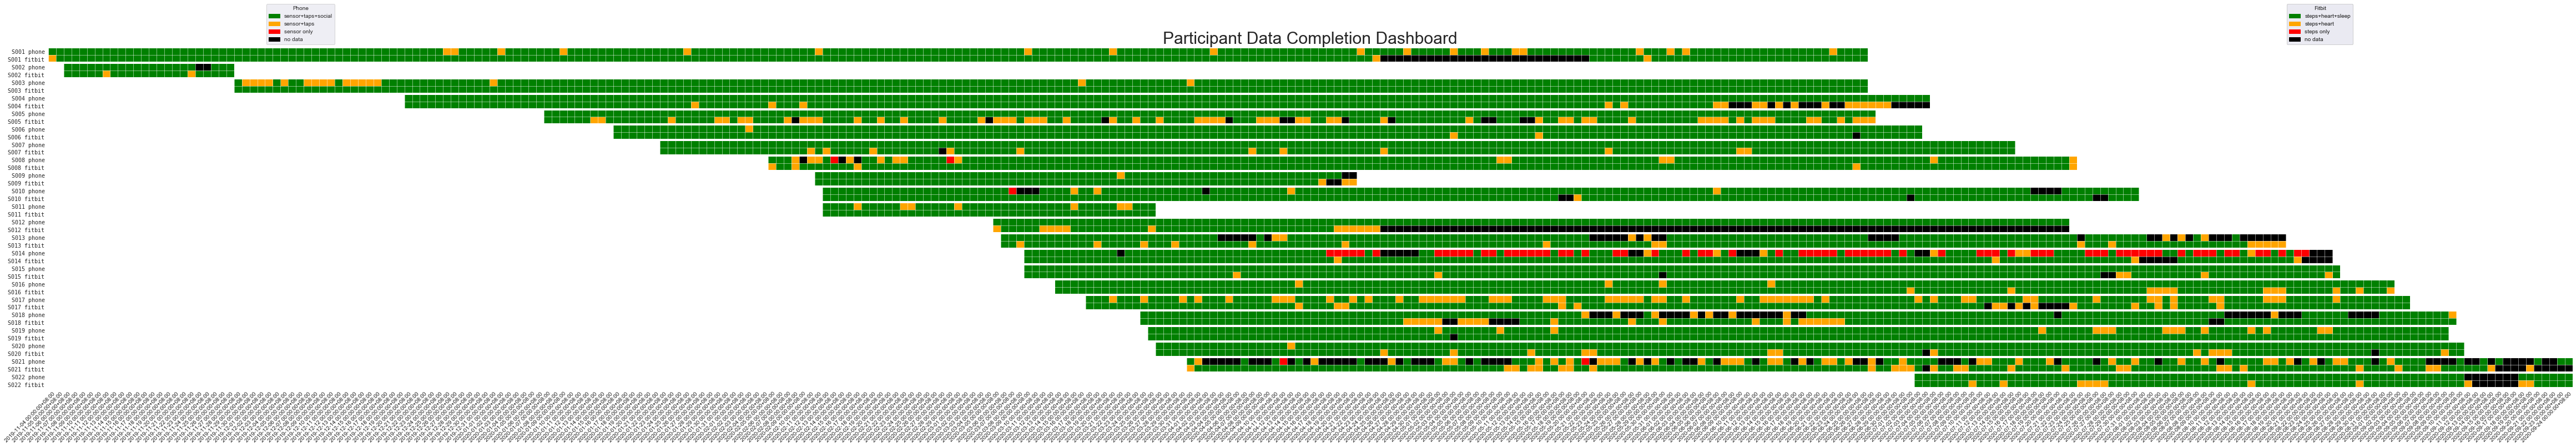

,accel,accessibilityLog,ambientLight,callLog,gps,heart,powerState,sleep,smsLog,sociabilityCallLog,sociabilityMsgLog,steps,tapsLog
S001,207,235,235,235,235,208,235,205,235,235,235,235,235
S002,20,20,20,21,20,22,20,20,21,21,21,22,20
S003,210,211,211,211,211,211,211,211,211,211,211,211,211
S004,197,197,197,197,197,174,197,164,197,197,197,192,197
S005,172,172,172,172,168,158,172,101,172,172,172,172,172
S006,169,169,169,169,169,168,169,166,169,169,169,169,169
S007,175,175,175,175,175,174,175,163,175,175,175,175,175
S008,159,158,159,163,166,169,165,164,163,163,163,169,164
S009,65,67,68,84,64,67,68,65,84,84,84,70,66
S010,162,161,160,162,162,165,161,164,162,162,162,170,161


,accel,accessibilityLog,ambientLight,callLog,gps,heart,powerState,sleep,smsLog,sociabilityCallLog,sociabilityMsgLog,steps,tapsLog
S001,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000
S002,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
S003,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000
S004,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000
S005,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000
S006,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000
S007,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000
S008,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000
S009,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
S010,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000


In [79]:
def merge_stat(dfs, max_datetime):
    s = pd.DataFrame([df['timestamp'].groupby(pd.Grouper(freq='D')).count() for df in dfs if len(df.index)]).transpose().sum(axis=1)
    return pd.DataFrame({'timestamp':s}) if s.size else pd.DataFrame({'timestamp':[0]}, index=[max_datetime])

def get_date_info(fn):
    df = pd.read_excel('/home/HOPES/HOPES-date-info.xlsx')
    df['END'] = df.apply(lambda r: pd.to_datetime(r['TERMINATION'] if type(r['VISIT 5'])!=str else r['VISIT 5']).tz_localize('tzlocal()'), axis=1)
    df['BEGIN'] = df.apply(lambda r: pd.to_datetime(' '.join(r['ONBOARDING'].split()[:3])).tz_localize('tzlocal()'), axis=1)
    return df[['PARTICIPANT', 'BEGIN', 'END']].set_index('PARTICIPANT')

def get_stat(fn, df, th, meta, begin_date, end_date):
    end_date += pd.to_timedelta('1D')
    total_days = (end_date-begin_date)/pd.to_timedelta('1D')
    if th>0:
        cnt = df.sort_index()[begin_date:end_date]['timestamp'].groupby(pd.Grouper(freq='1D')).count()>=th
        return cnt.sum(), total_days
    else:
        dfm = pd.Series(1, index=pd.to_datetime(os.meta['accel'], unit='ms', utc=True).tz_convert('tzlocal()')).groupby(pd.Grouper(freq='D')).sum()>1
        return dfm.sum(), total_days

def monitor(lastN=400, verbose=1):
    os.df_dates = df_dates = get_date_info('/home/HOPES/HOPES-date-info.xlsx')
    fmap = {'ambientLight.csv.gz':24, 'accessibilityLog.csv.gz':2, 'tapsLog.csv.gz':2, 'callLog.csv.gz':0, 'smsLog.csv.gz':0, 'sociabilityMsgLog.csv.gz':0,
            'sociabilityCallLog.csv.gz':0, 'heart.csv.gz':24, 'sleep.csv.gz':1, 'steps.csv.gz':24, 'accel.csv.gz':24, 'gps.csv.gz':1, 'powerState.csv.gz':2}
    df = pd.DataFrame()
    df_stat = pd.DataFrame(columns=sorted([s.split('.')[0] for s in fmap]))
    df_num = df_stat.copy()
    df_den = df_stat.copy()
    for username in dropdown_userlist.options:
        UID = 'S'+username[10:13]
        if UID not in df_dates.index: continue
        
        if not os.path.isfile(PATH + '/' + username + '/ambientLight.csv.gz'):
            if verbose>0: print('Skipping User %s' % username)
            continue

        if verbose>0:print('Loading data from %s ' % username, end='')
        os.meta = meta = json.load(Open(PATH + '/' + username + '/meta.json.gz'))
        os.dfs = dfs = [(load_df(PATH + '/' + username + '/' +fn, '', -1, low_memory=False), print('.' if verbose>0 else '', end='', flush=True))[0] for fn in fmap]
        
        for fn, df1 in zip(fmap.keys(), dfs):
            n_pass, n_total = get_stat(fn, df1, fmap[fn], meta, df_dates.loc[UID,'BEGIN'], df_dates.loc[UID,'END'])
            sn = fn.split('.')[0]
            if verbose>0: print('%s=%d/%d'%(sn, n_pass, n_total), end=' ', flush=True)
            df_num.loc[UID, sn] = n_pass
            df_den.loc[UID, sn] = n_total
            df_stat.loc[UID, sn] = n_pass/n_total

        try:
            max_datetime = max([df.index.max() for df in dfs if len(df.index)]).floor('D')
        except:
            if verbose > 0: print('Skip')
            continue

        os.all5 = phone1, phone2, phone3, fitbit1, fitbit2 = [merge_stat([dfs[i] for i in s], max_datetime) for s in [[0], [1, 2], [3, 4, 5, 6], [7], [8]]]

        # Fitbit steps need to sum over every day group
        fitbit0 = (dfs[9] if len(dfs[9].index) else pd.DataFrame({'StepsCount': [0]},
                   index=[max_datetime]))[['StepsCount']].groupby(pd.Grouper(freq='D')).sum()

        # Build phone colors
        phoneC = pd.concat([phone1, phone2, phone3], axis=1).fillna(0).sort_index() \
            .apply(lambda x: 3 if x[2] else (2 if x[1] else (1 if x[0] else 0)), axis=1)

        # Build Fitbit colors
        fitbitC = pd.concat([fitbit0, fitbit1, fitbit2], axis=1).fillna(0).sort_index() \
            .apply(lambda x: 3 if x[2] else (2 if x[1] else (1 if x[0] else 0)), axis=1)
        
        df = df.join(pd.DataFrame({UID+' phone': phoneC, UID + ' fitbit':fitbitC}), how='outer')

        if verbose>0:print('Done')
            
    # outside study period set to 0
    oneday = pd.to_timedelta('1D')
    for PID, (first_date, last_date) in df_dates.iterrows():
        for fea in [' phone', ' fitbit']:
            df.loc[:first_date-oneday, PID+fea] = -1
            df.loc[last_date+oneday:, PID+fea] = -1
    df = df.loc[df_dates['BEGIN'].min():df_dates['END'].max(), :]
    
    # print overall completion rate table
    df_stat['<AggMEAN>'] = df_num.sum(axis=1)/df_den.sum(axis=1)
    df_stat.loc['<AggMEAN>', :] = df_num.sum(axis=0)/df_den.sum(axis=0)
    df_stat.loc['<AggMEAN>', '<AggMEAN>'] = df_num.values.sum()/df_den.values.sum()
    display(HTML('\n<b><font color=red>Data Completion rate:</b></font>'), df_stat)
        
    print('Plotting dashboard ...')
    plt.switch_backend('module://ipykernel.pylab.backend_inline')
    os.df = df = df.fillna(0).astype(int)
    os.data = data = df.transpose()
    
    # draw 2D grid
    Nx, Ny = len(data.columns), len(data.index)
    fig, ax = plt.subplots(figsize=(Nx/4,Ny))
    ax.title.set_size(30)
    ax.title.set_text('Participant Data Completion Dashboard')
    cmap = colors.ListedColormap(['white', 'black', 'red', 'orange', 'green'])
    norm = colors.BoundaryNorm([-1.5,-0.5,0.5,1.5,2.5,3.5], cmap.N)
    ax.grid(False)
    ax.imshow(data, cmap=cmap, norm=norm)

    # x-axis is the date
    ax.set_xticklabels('')
    ax.set_xticks(np.arange(0.5, Nx+0.5, 1), minor=True)
    ax.set_xticklabels(data.columns, minor=True, rotation=45, ha='right')
    ax.xaxis.grid(True, which='minor', linewidth=0.5)
    
    # y-axis is the Patient ID
    ax.set_yticks(np.arange(-0.5, Ny+0.5, 2))
    ax.set_yticklabels(['']+[re.sub('@[^ ]* ',' ',s) for s in data.index[1::2]], fontdict={'family':'monospace'}, va='bottom')
    ax.yaxis.grid(True, which='major', linewidth=4)
    
    ax.set_yticks(np.arange(0.5, Ny+0.5, 2), minor=True)
    ax.set_yticklabels([re.sub('@[^ ]* ',' ',s) for s in data.index[0::2]], fontdict={'family':'monospace'}, minor=True, va='bottom')
    ax.yaxis.grid(True, which='minor', linewidth=0.5)
    
    # legend
    ax.add_artist(plt.legend(handles=[Patch(color='green', label='sensor+taps+social'), Patch(color='orange', label='sensor+taps'),
                        Patch(color='red', label='sensor only'), Patch(color='black', label='no data')], title='Phone',
                        loc='lower center', bbox_to_anchor=(0.1, 1)))
    ax.add_artist(plt.legend(handles=[Patch(color='green', label='steps+heart+sleep'), Patch(color='orange', label='steps+heart'),
                        Patch(color='red', label='steps only'), Patch(color='black', label='no data')], title='Fitbit',
                        loc='lower center', bbox_to_anchor=(0.9, 1)))

    plt.show()
    display(HTML('\n<b><font color=red>Numerator (number of days having feature data):</b></font>'), df_num)
    display(HTML('\n<b><font color=red>Denominator (number of days enrolled in the study):</b></font>'), df_den)
    
button = widgets.Button(description="Start Check")
button.on_click(monitor)
display(button)

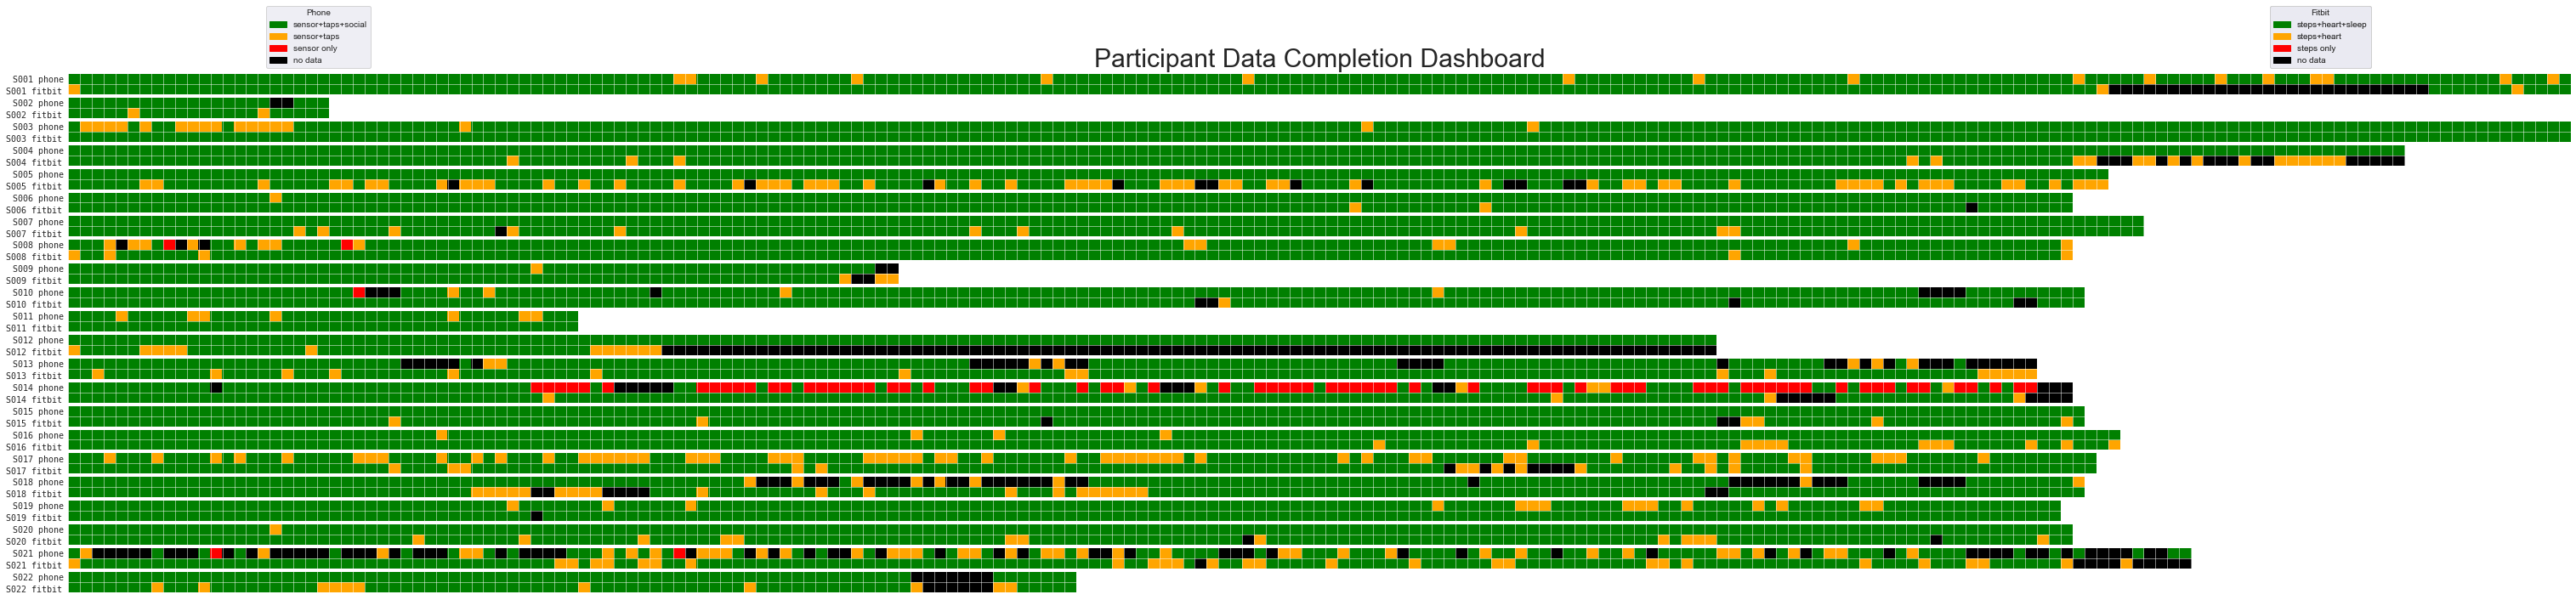

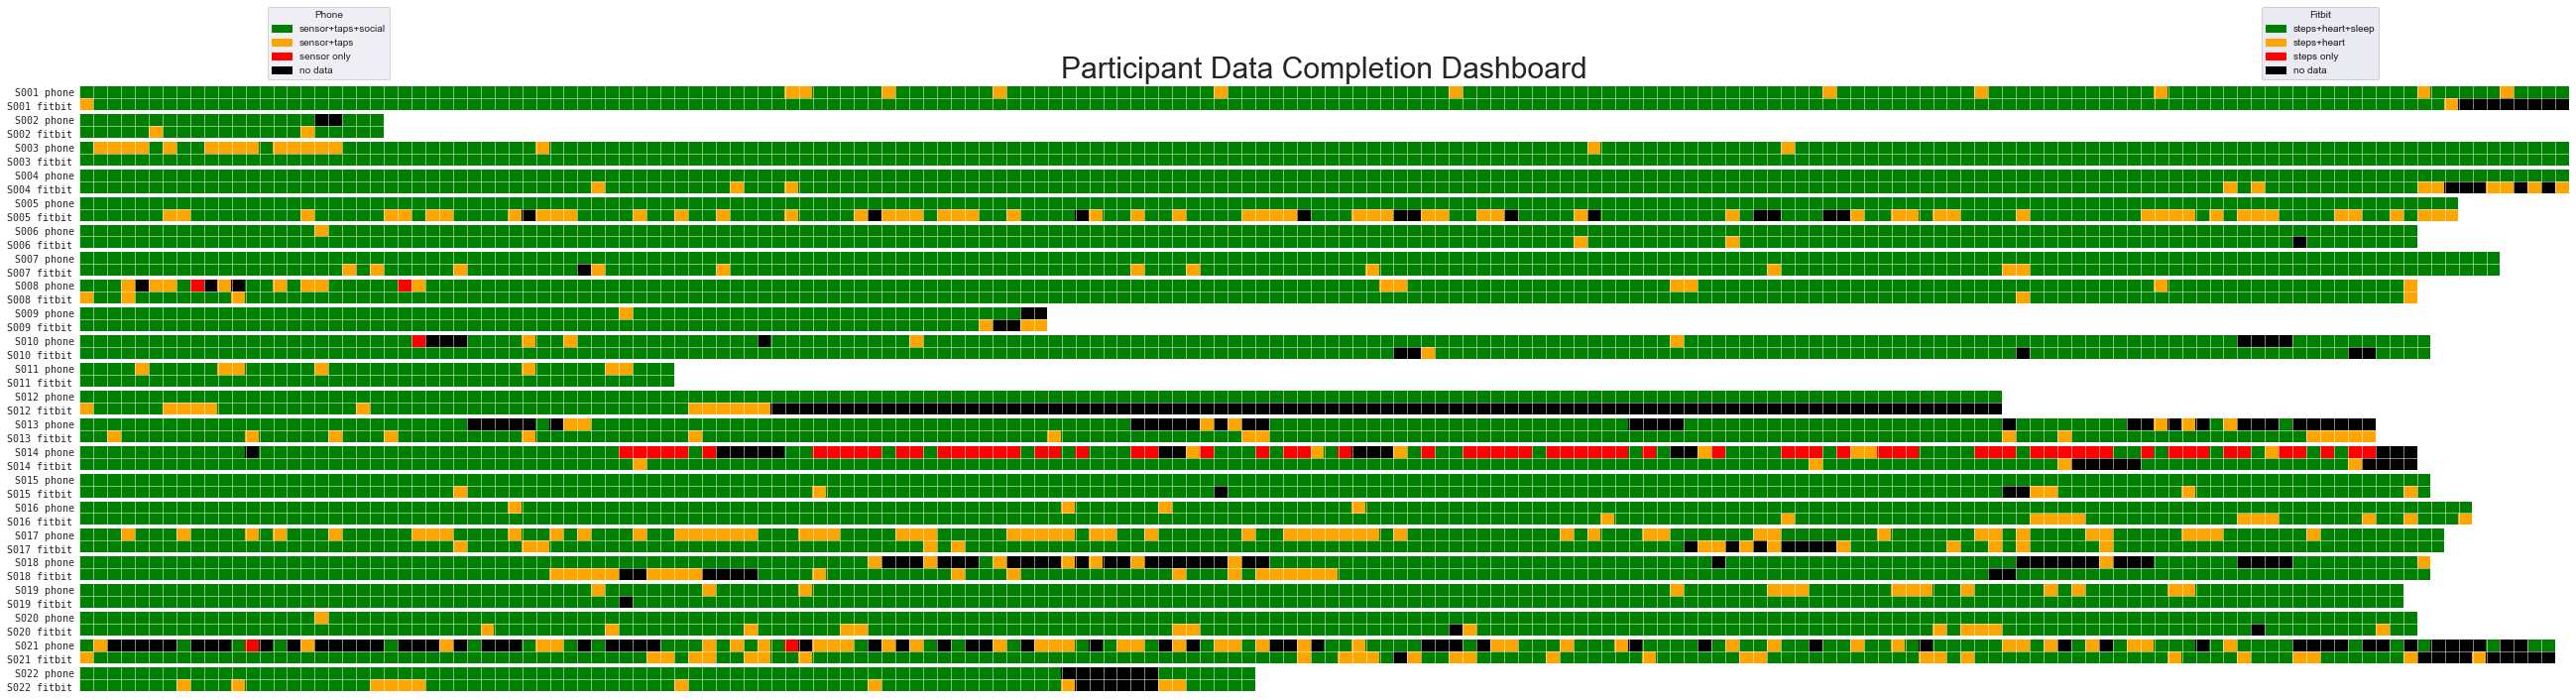

In [89]:
def align_begin(df_, r=1):
    df = df_.copy()
    n_max = 0
    for i in range(2, df.index.size, 2):
        L = [v!=-1 for v in df.iloc[i, :].values.tolist()]
        posi = L.index(True)
        n_max = max(n_max, L.count(True))
        df.iloc[i:i+2, 0:-posi] = df.iloc[i:i+2, posi:].values
        df.iloc[i:i+2, -posi:] = -1
    return df.iloc[:, :(int(n_max*r) if r<=1 else r)]


def draw(r=1):
    data = align_begin(os.data, r)

    # draw 2D grid
    Nx, Ny = len(data.columns), len(data.index)
    fig, ax = plt.subplots(figsize=(Nx/4,Ny))
    ax.title.set_size(30)
    ax.title.set_text('Participant Data Completion Dashboard')
    cmap = colors.ListedColormap(['white', 'black', 'red', 'orange', 'green'])
    norm = colors.BoundaryNorm([-1.5,-0.5,0.5,1.5,2.5,3.5], cmap.N)
    ax.grid(False)
    ax.imshow(data, cmap=cmap, norm=norm)

    # x-axis is the date
    ax.set_xticklabels('')
    ax.set_xticks(np.arange(0.5, Nx+0.5, 1), minor=True)
#     ax.set_xticklabels(data.columns, minor=True, rotation=45, ha='right')
    ax.xaxis.grid(True, which='minor', linewidth=0.5)

    # y-axis is the Patient ID
    ax.set_yticks(np.arange(-0.5, Ny+0.5, 2))
    ax.set_yticklabels(['']+[re.sub('@[^ ]* ',' ',s) for s in data.index[1::2]], fontdict={'family':'monospace'}, va='bottom')
    ax.yaxis.grid(True, which='major', linewidth=4)

    ax.set_yticks(np.arange(0.5, Ny+0.5, 2), minor=True)
    ax.set_yticklabels([re.sub('@[^ ]* ',' ',s) for s in data.index[0::2]], fontdict={'family':'monospace'}, minor=True, va='bottom')
    ax.yaxis.grid(True, which='minor', linewidth=0.5)

    # legend
    ax.add_artist(plt.legend(handles=[Patch(color='green', label='sensor+taps+social'), Patch(color='orange', label='sensor+taps'),
                        Patch(color='red', label='sensor only'), Patch(color='black', label='no data')], title='Phone',
                        loc='lower center', bbox_to_anchor=(0.1, 1)))
    ax.add_artist(plt.legend(handles=[Patch(color='green', label='steps+heart+sleep'), Patch(color='orange', label='steps+heart'),
                        Patch(color='red', label='steps only'), Patch(color='black', label='no data')], title='Fitbit',
                        loc='lower center', bbox_to_anchor=(0.9, 1)))

    plt.show()
    
draw()
draw(180)